# Load Line P CTD casts
Author: Hayley Dosser
Created: October, 2025

Load and do some simple processing on CTD casts/profiles that were collected as part of the DFO Line P cruise program, then extracted from waterproperties.ca by Amber Holdsworth and made available via https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/observations/binned/. 

In [1]:
import datetime
import gsw
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pathlib
import xarray as xr

## User-specified parameters

In [2]:
path = '/home/sbeairsto/projects/line_p/data/physical'

## Load all CTD data into a Pandas dataframe

In [3]:
# Load the Line P CTD data one file at a time, extract the subset we want, and move it into timeseries for each depth and station
ctd_years = np.arange(1969,2021,1)

df_list = []
#for i, n in enumerate(ctd_years):
    # load the file for each year
df_temp = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/CTD_training.csv',delimiter=',') 

# remove data from P1 to P3 (the coastal stations)
drop_condition = (df_temp['closest_linep_station_name']=='P1') | (df_temp['closest_linep_station_name']=='P2') | (df_temp['closest_linep_station_name']=='P3') 
df_temp = df_temp.drop(df_temp[drop_condition].index)

# remove data further than 500m away from a Line P station (optional)
drop_condition = df_temp['distance_to_closest_station_km']>.5
df_temp = df_temp.drop(df_temp[drop_condition].index)

#add the dataframe into the list of dataframes
df = df_temp

## Take a look at the CTD data

In [19]:
df[df['time'].str.startswith('2010-06')]

,time,file,CTDPRS_DBAR,CTDTMP_ITS90_DEG_C,SALINITY_PSS78,latitude,longitude,OXYGEN_MMOL_M3,OXYGEN_UMOL_KG,closest_linep_station_name,distance_to_closest_station_km,PRS_bin_cntr
748177,2010-06-17 03:37:36,P26_CastCTD_2010-06-17_0337h.nc,2.2,7.6257,32.7087,49.998665,-144.999664,305.510,298.3,P26,0.150388,2.5
748178,2010-06-17 03:37:36,P26_CastCTD_2010-06-17_0337h.nc,3.1,7.6265,32.7088,49.998665,-144.999664,305.956,298.5,P26,0.150388,3.5
748179,2010-06-17 03:37:36,P26_CastCTD_2010-06-17_0337h.nc,3.9,7.6278,32.7089,49.998665,-144.999664,305.510,298.0,P26,0.150388,3.5
748180,2010-06-17 03:37:36,P26_CastCTD_2010-06-17_0337h.nc,5.0,7.6287,32.7090,49.998665,-144.999664,305.510,298.4,P26,0.150388,5.5
748181,2010-06-17 03:37:36,P26_CastCTD_2010-06-17_0337h.nc,6.0,7.6284,32.7090,49.998665,-144.999664,305.956,298.5,P26,0.150388,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...
884436,2010-06-18 10:39:38,P25_CastCTD_2010-06-18_1039h.nc,2001.0,1.9088,34.5881,50.000832,-143.605164,47.276,46.0,P25,0.093206,2001.5
884437,2010-06-18 10:39:38,P25_CastCTD_2010-06-18_1039h.nc,2003.0,1.9086,34.5881,50.000832,-143.605164,47.276,46.1,P25,0.093206,2003.5
884438,2010-06-18 10:39:38,P25_CastCTD_2010-06-18_1039h.nc,2004.0,1.9083,34.5881,50.000832,-143.605164,47.722,46.3,P25,0.093206,2004.5
884439,2010-06-18 10:39:38,P25_CastCTD_2010-06-18_1039h.nc,2005.0,1.9081,34.5882,50.000832,-143.605164,47.276,46.0,P25,0.093206,2005.5


## Calculate new variables of interest and add them to the data frame
Plus rename some variables for simplicity

In [ ]:
# Create a new variable with the date in a format we can work with
to_datetime = lambda x: datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S')
df['TIME'] = df['time'].apply(to_datetime)

# Move from pressure to depth levels
fld = -gsw.z_from_p(df.CTDPRS_DBAR,df.latitude)
df['DEPTH'] = fld

# Set questionable salinity values to NaN
bad_salinity = (df['SALINITY_PSS78'] < 0) | (df['SALINITY_PSS78'] > 40)
df.loc[bad_salinity, 'SALINITY_PSS78'] = np.nan

# Rename variables
df = df.rename(columns={"latitude": "LATITUDE"})
df = df.rename(columns={"longitude": "LONGITUDE"})
df = df.rename(columns={"CTDPRS_DBAR": "PRESSURE"})
df = df.rename(columns={"CTDTMP_ITS90_DEG_C": "TEMPERATURE"})
df = df.rename(columns={"SALINITY_PSS78": "SALINITY"})
df = df.rename(columns={"OXYGEN_UMOL_KG": "OXYGEN"})
df = df.rename(columns={"closest_linep_station_name": "STATION_ID"})

AttributeError: 'DataFrame' object has no attribute 'CTDPRS_DBAR'

### Quick look at the distribution for each variable

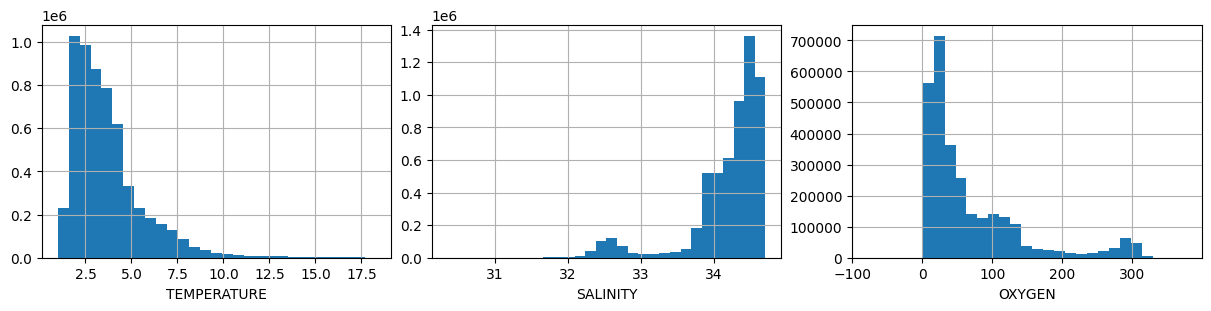

In [9]:
var_list = ['TEMPERATURE','SALINITY','OXYGEN']
fig, ax = plt.subplots(1, ncols=3, constrained_layout=True, figsize=(12, 3))

for n, var in enumerate(var_list):
    fld = df[var].values   

    bins = np.arange(np.nanmin(fld),np.nanmax(fld),(np.nanmax(fld)-np.nanmin(fld))/30)
    ax[n].hist(fld,bins,alpha=1)
    ax[n].set_xlabel(var)
    ax[n].grid()

In [10]:
df

,time,file,PRESSURE,TEMPERATURE,SALINITY,LATITUDE,LONGITUDE,OXYGEN_MMOL_M3,OXYGEN,STATION_ID,distance_to_closest_station_km,PRS_bin_cntr,TIME,DEPTH
0,1969-08-26 22:18:00,P_CastCTD_1969-08-26_2218h.nc,0.000000,12.3000,32.5200,50.000000,-145.00000,NaN,NaN,P26,0.000000,0.5,1969-08-26 22:18:00,0.000000
1,1969-08-26 22:18:00,P_CastCTD_1969-08-26_2218h.nc,5.043289,12.1500,32.5200,50.000000,-145.00000,NaN,NaN,P26,0.000000,5.5,1969-08-26 22:18:00,5.000000
2,1969-08-26 22:18:00,P_CastCTD_1969-08-26_2218h.nc,10.086701,12.1200,32.5200,50.000000,-145.00000,NaN,NaN,P26,0.000000,10.5,1969-08-26 22:18:00,10.000000
3,1969-08-26 22:18:00,P_CastCTD_1969-08-26_2218h.nc,20.173897,12.0700,32.5200,50.000000,-145.00000,NaN,NaN,P26,0.000000,20.5,1969-08-26 22:18:00,20.000001
4,1969-08-26 22:18:00,P_CastCTD_1969-08-26_2218h.nc,26.226450,12.0500,32.5200,50.000000,-145.00000,NaN,NaN,P26,0.000000,26.5,1969-08-26 22:18:00,26.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147009,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2001.000000,1.9819,34.5800,49.350166,-135.66684,53.52,52.0,P17,0.021078,2001.5,2020-02-13 12:39:40,1974.521684
147010,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2002.000000,1.9802,34.5804,49.350166,-135.66684,53.52,52.0,P17,0.021078,2002.5,2020-02-13 12:39:40,1975.503826
147011,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2003.000000,1.9801,34.5804,49.350166,-135.66684,53.52,52.0,P17,0.021078,2003.5,2020-02-13 12:39:40,1976.485963
147012,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2004.000000,1.9800,34.5805,49.350166,-135.66684,53.52,52.0,P17,0.021078,2004.5,2020-02-13 12:39:40,1977.468096


## Write pre-processed data to CSV

In [39]:
# Text for the CSV file header
header_text = """
# Description: CTD casts/profiles collected as part of the DFO Line P cruise program 
# then extracted from waterproperties.ca by Amber Holdsworth, made available via 
# https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/observations/binned/, 
# and pre-processed for the SD-Ocean Line P Hackathon in October 2025. 
# Temperature, salinity, and oxygen are collected using sensors lowered through the 
# water column at or near Line P stations.  
# 
# Coordinates:
# STATION_ID for Line P stations P4 to P26
# TIME in UTC between 1969 to 2020 
# LATITUDE in decimal degrees
# LONGITUDE in decimal degrees
# DEPTH in m
# PRESSURE in dbar
# 
# Variables: 
# TEMPERATURE in degrees Celcius (in-situ)
# SALINITY PSS-78
# OXYGEN in µmol/kg (dissolved oxygen)

"""

In [41]:
# Write the variables to CSV
variable_list = [
    'STATION_ID',
    'TIME',
    'LATITUDE',
    'LONGITUDE',
    'DEPTH',
    'PRESSURE',
    'TEMPERATURE',
    'SALINITY',
    'OXYGEN'
]

with open("DFO_LineP_CTDdata.csv","w") as f:
    f.write(header_text)
    df[variable_list].to_csv(f,index=False,na_rep="NaN")